In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt
from datetime import date, timedelta
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as sp
import statsmodels.api as sm
from plotly.subplots import make_subplots
import itertools
import requests
import yfinance as yf
from datetime import datetime, timedelta


### Partie 1: Téléchargement des bases de données trimestrielle du CPI, GDP et Taux d'intérét

In [2]:
api_key = "8e877013bcb3862ac90cd864024bdb75"

def download_fred_data(series_id, start_date, end_date):
    url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&observation_start={start_date}&observation_end={end_date}&file_type=json"
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data['observations'])
    df['date'] = pd.to_datetime(df['date'])
    df[series_id] = pd.to_numeric(df['value'], errors='coerce')
    df = df[['date', series_id]]
    df.set_index('date', inplace=True)
    return df

gdp_data = download_fred_data("GDPC1", "2000-01-01", "2025-12-31")
inflation_data = download_fred_data("CPIAUCNS", "2000-01-01", "2025-12-31")
interest_rate_data = download_fred_data("FEDFUNDS","2000-01-01", "2025-12-31")

gdp_data['GDPC1'] = pd.to_numeric(gdp_data['GDPC1'], errors='coerce')
inflation_data['CPIAUCNS'] = pd.to_numeric(inflation_data['CPIAUCNS'], errors='coerce')
interest_rate_data['FEDFUNDS'] = pd.to_numeric(interest_rate_data['FEDFUNDS'], errors='coerce')

gdp_data.reset_index(inplace=True)

inflation_data.insert(0,"Date",inflation_data.index,True)
inflation_data["Date"]=inflation_data.index
inflation_data.reset_index(drop=True, inplace=True)
inflation_data['date'] = pd.to_datetime(inflation_data['Date'])
inflation_data['Quarter'] = inflation_data['date'].dt.to_period('Q')
inflation_data_quarterly = inflation_data.groupby('Quarter').mean().reset_index()
premiere_dates_trimestre = inflation_data.groupby('Quarter')['date'].first().reset_index()
inflation_data_quarterly['date'] = premiere_dates_trimestre['date']
inflation_data_quarterly = inflation_data_quarterly.reindex(columns=['date', 'CPIAUCNS'])

interest_rate_data.insert(0,"date",interest_rate_data.index,True)
interest_rate_data["date"]=interest_rate_data.index
interest_rate_data.reset_index(drop=True, inplace=True)
interest_rate_data['date'] = pd.to_datetime(interest_rate_data['date'])
interest_rate_data['Quarter'] = interest_rate_data['date'].dt.to_period('Q')
interest_rate_data_quarterly = interest_rate_data.groupby('Quarter').mean().reset_index()
premiere_dates_trimestre = interest_rate_data.groupby('Quarter')['date'].first().reset_index()
interest_rate_data_quarterly['date'] = premiere_dates_trimestre['date']
interest_rate_data_quarterly = interest_rate_data_quarterly.reindex(columns=['date', 'FEDFUNDS'])

inflation_data_quarterly['Inflation_Growth_Rate'] = inflation_data_quarterly['CPIAUCNS'].pct_change()
inflation_data_quarterly['Previous_Inflation_Growth_Rate'] = inflation_data_quarterly['Inflation_Growth_Rate'].shift(1)

gdp_data['GDP_Growth_Rate'] = gdp_data['GDPC1'].pct_change()
gdp_data['Previous_GDP_Growth_Rate'] = gdp_data['GDP_Growth_Rate'].shift(1)

interest_rate_data_quarterly['FEDFUNDS_Growth_Rate'] = interest_rate_data_quarterly['FEDFUNDS'].pct_change()
interest_rate_data_quarterly['Previous_FEDFUNDS_Growth_Rate'] = interest_rate_data_quarterly['FEDFUNDS_Growth_Rate'].shift(1)

merged_data = pd.merge(gdp_data, inflation_data_quarterly, on='date')
merged_data = pd.merge(merged_data, interest_rate_data_quarterly, on='date')

merged_data_rate = merged_data.drop(columns=['Previous_GDP_Growth_Rate', 'Previous_Inflation_Growth_Rate', 'Previous_FEDFUNDS_Growth_Rate'])
merged_data_rate

,date,GDPC1,GDP_Growth_Rate,CPIAUCNS,Inflation_Growth_Rate,FEDFUNDS,FEDFUNDS_Growth_Rate
0,2000-01-01,13878.147,NaN,169.933333,NaN,5.676667,NaN
1,2000-04-01,14130.908,0.018213,171.733333,0.010592,6.273333,0.105109
2,2000-07-01,14145.312,0.001019,173.100000,0.007958,6.520000,0.039320
3,2000-10-01,14229.765,0.005970,174.033333,0.005392,6.473333,-0.007157
4,2001-01-01,14183.120,-0.003278,175.700000,0.009577,5.593333,-0.135942
...,...,...,...,...,...,...,...
97,2024-04-01,23286.508,0.008855,313.930667,0.011510,5.330000,0.000000
98,2024-07-01,23478.570,0.008248,314.879000,0.003021,5.263333,-0.012508
99,2024-10-01,23586.542,0.004599,315.587333,0.002250,4.650000,-0.116529
100,2025-01-01,23548.210,-0.001625,318.850667,0.010341,4.330000,-0.068817


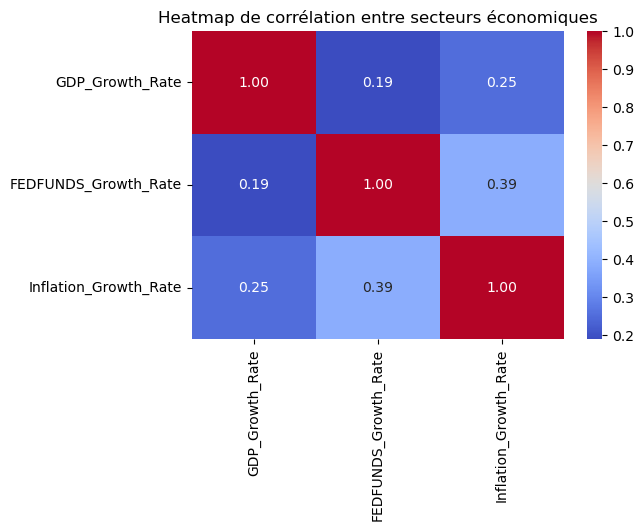

In [3]:
correlation_matrix = merged_data[['GDP_Growth_Rate', 'FEDFUNDS_Growth_Rate', 'Inflation_Growth_Rate']].corr()

plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap de corrélation entre secteurs économiques')
plt.show()

### Partie 2: Analyse du comportement du GDP et du Taux d'intérét en fonction des scénarios de variabilité du CPI

**Scénarios traités pour CPI: Hyperinflation, Déflation, Stagflation, Inflation élevée, Inflation modérée, Désinflation et Reprise après Déflation**

In [4]:
def assign_scenario(row):
    inflation_growth_rate = row['Inflation_Growth_Rate']
    previous_inflation_growth_rate = row['Previous_Inflation_Growth_Rate']

    if inflation_growth_rate >= 0.5:
        scenario = "Hyperinflation"
    elif inflation_growth_rate < -0.02 and inflation_growth_rate < previous_inflation_growth_rate:
        scenario = "Déflation"
    elif inflation_growth_rate > 0.05 and inflation_growth_rate > previous_inflation_growth_rate:
        scenario = "Stagflation"
    elif 0.02 < inflation_growth_rate <= 0.05 and inflation_growth_rate > previous_inflation_growth_rate:
        scenario = "Inflation élevée"
    elif -0.02 <= inflation_growth_rate <= 0.02 and inflation_growth_rate > previous_inflation_growth_rate:
        scenario = "Inflation modérée"
    elif inflation_growth_rate < previous_inflation_growth_rate:
        scenario = "Désinflation"
    elif inflation_growth_rate < -0.02 and inflation_growth_rate > previous_inflation_growth_rate:
        scenario = "Reprise après Déflation"
    else:
        scenario = None
    return scenario

merged_data['Scenario'] = merged_data.apply(assign_scenario, axis=1)

scenario_data = merged_data[['date', 'Scenario']].dropna()
scenario_data

,date,Scenario
2,2000-07-01,Désinflation
3,2000-10-01,Désinflation
4,2001-01-01,Inflation modérée
5,2001-04-01,Inflation modérée
6,2001-07-01,Désinflation
...,...,...
97,2024-04-01,Inflation modérée
98,2024-07-01,Désinflation
99,2024-10-01,Désinflation
100,2025-01-01,Inflation modérée


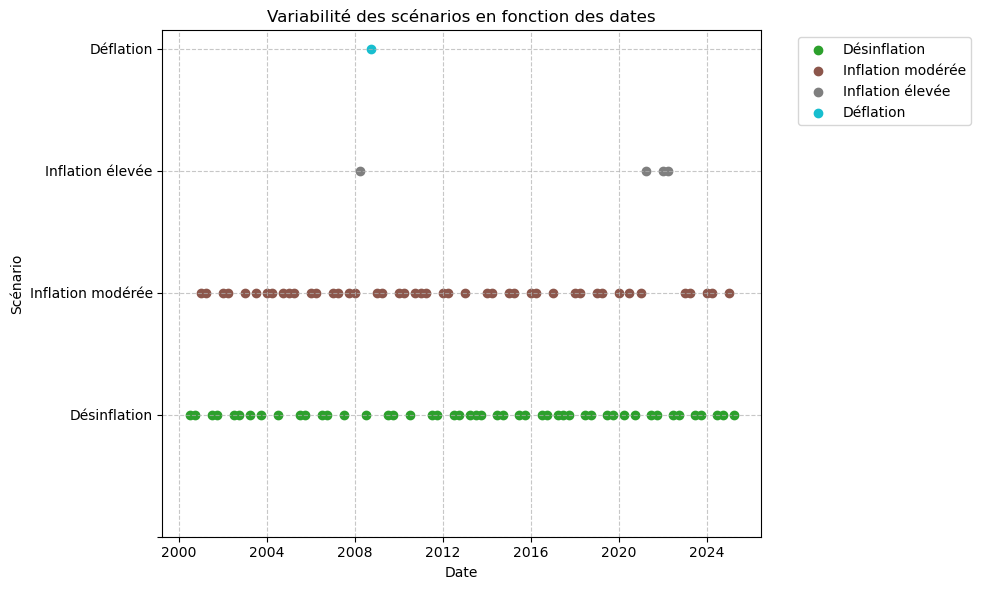

In [5]:
growth_rate = merged_data.drop(columns=['GDPC1', 'CPIAUCNS', 'FEDFUNDS', 'Previous_GDP_Growth_Rate', 'Previous_Inflation_Growth_Rate', 'Previous_FEDFUNDS_Growth_Rate'])

plt.figure(figsize=(10, 6))

unique_scenarios = growth_rate['Scenario'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_scenarios)))

for i, scenario in enumerate(unique_scenarios):
    scenario_data_subset = growth_rate[growth_rate['Scenario'] == scenario]
    plt.scatter(scenario_data_subset['date'], [i] * len(scenario_data_subset), color=colors[i], label=scenario)

plt.title('Variabilité des scénarios en fonction des dates')
plt.xlabel('Date')
plt.ylabel('Scénario')

plt.xticks(rotation=0, ha='center')

plt.yticks(np.arange(len(unique_scenarios)), unique_scenarios)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [6]:
start_date = '2000-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

filtered_data = merged_data[(merged_data['date'] >= start_date) & (merged_data['date'] <= end_date)]

scenario_counts = filtered_data['Scenario'].value_counts().reset_index()
scenario_counts.columns = ['Scenario', 'Count']

fig = px.pie(scenario_counts, values='Count', names='Scenario', title=f'Répartition des scénarios entre {start_date} et {end_date}')
fig.show()

In [7]:
merged_all_data_encoded = pd.get_dummies(scenario_data, columns=['Scenario'])
merged_all_data_encoded_no_date = merged_all_data_encoded.drop(columns='date')

growth_rate_reset = growth_rate.reset_index(drop=True)

final_data_for_corr = pd.concat(
    [merged_all_data_encoded_no_date,
     growth_rate_reset[['GDP_Growth_Rate', 'FEDFUNDS_Growth_Rate', 'Inflation_Growth_Rate']]],
    axis=1
)

correlation = final_data_for_corr.corr()
correlation = correlation.loc[
    ['GDP_Growth_Rate', 'FEDFUNDS_Growth_Rate', 'Inflation_Growth_Rate'],
    [col for col in correlation.columns if 'Scenario_' in col]
]

correlation

,Scenario_Déflation,Scenario_Désinflation,Scenario_Inflation modérée,Scenario_Inflation élevée
GDP_Growth_Rate,-0.217740,-0.060385,0.102733,0.003316
FEDFUNDS_Growth_Rate,-0.133167,-0.093822,-0.041041,0.411341
Inflation_Growth_Rate,-0.466482,-0.394839,0.293683,0.497163


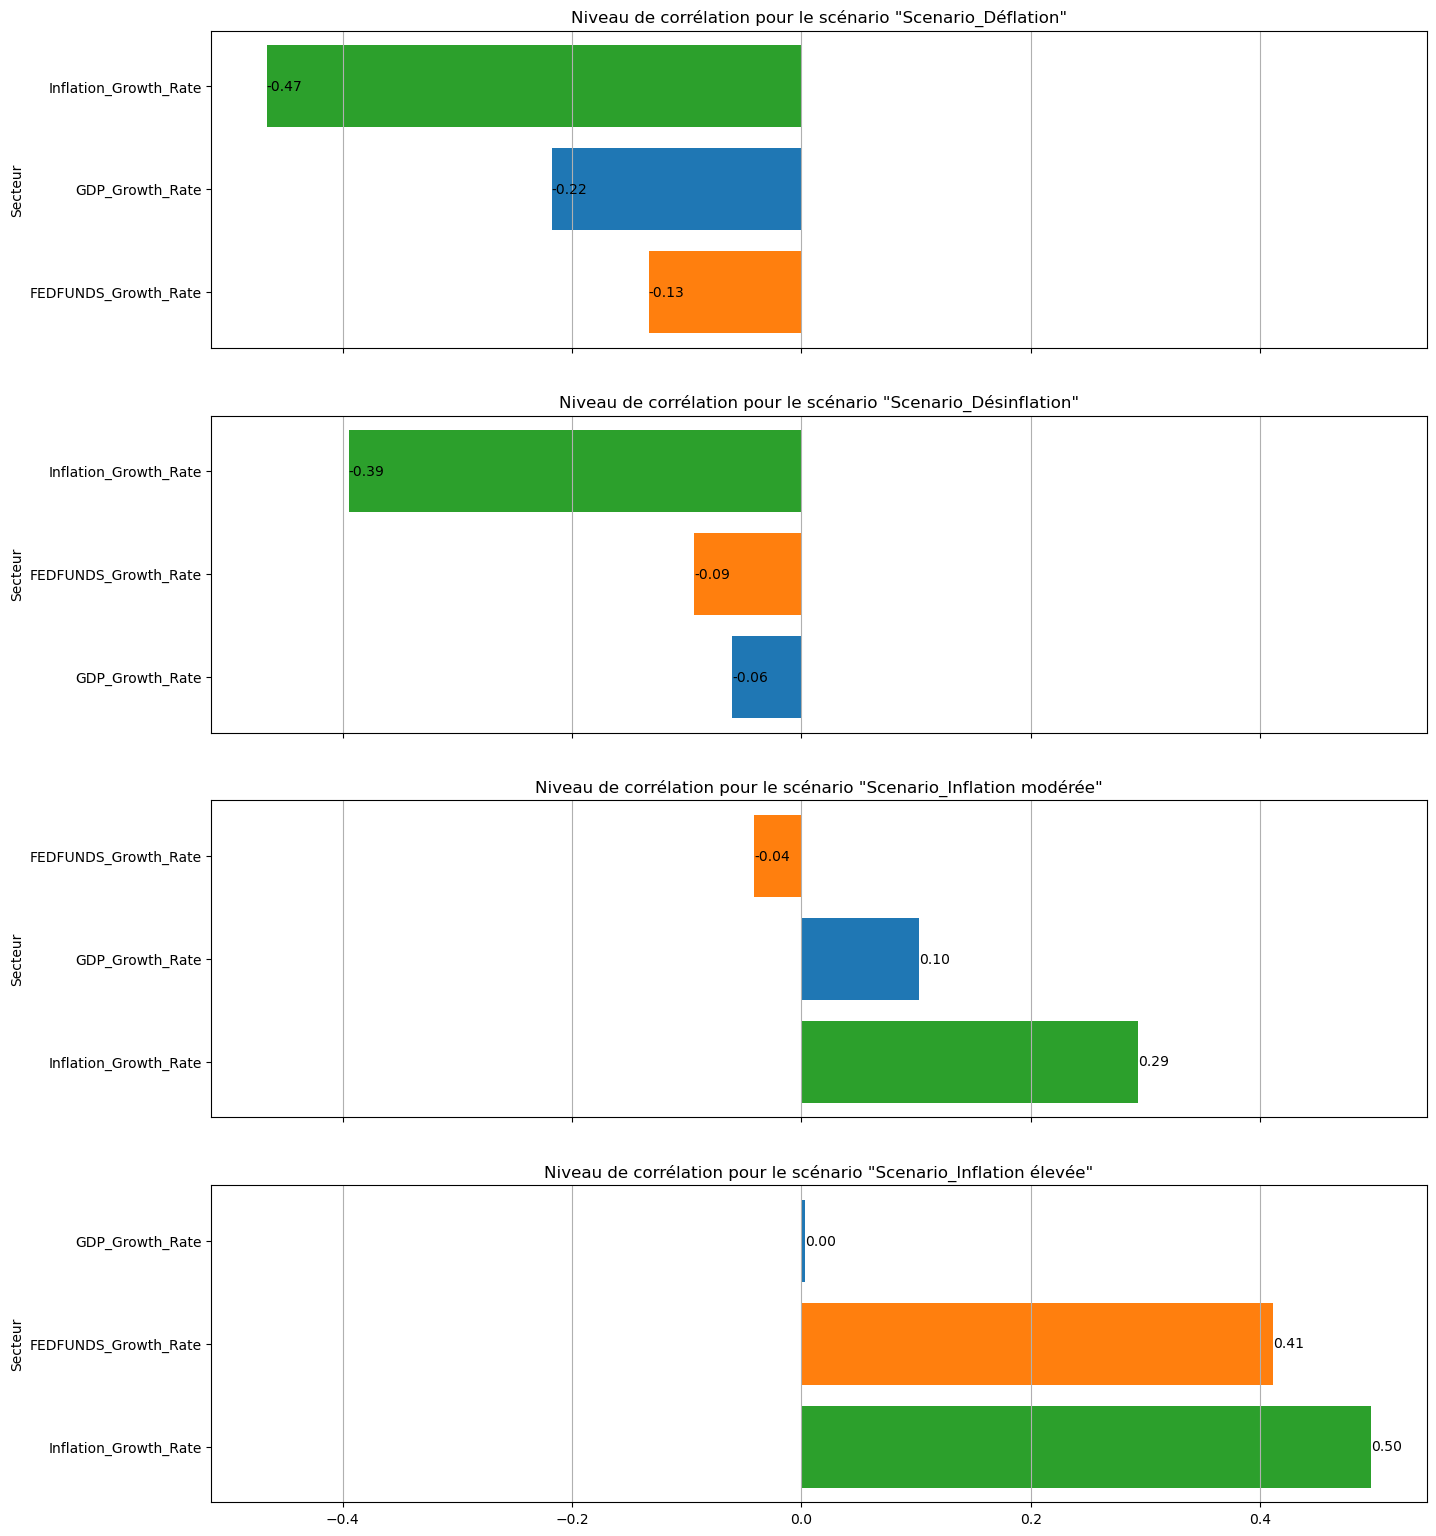

In [8]:
total_scenarios = len(correlation.columns)

sector_color_dict = {}
colors = plt.cm.tab10.colors[:len(correlation.index)]
for i, sector in enumerate(correlation.index):
    sector_color_dict[sector] = colors[i]

fig, axes = plt.subplots(total_scenarios, 1, figsize=(15, total_scenarios*4), sharex=True)

for i, scenario in enumerate(correlation.columns):
    sorted_sectors = correlation[scenario].sort_values(ascending=False)

    ax = axes[i]
    sectors = sorted_sectors.index
    scores = sorted_sectors.values

    colors = [sector_color_dict[sector] for sector in sectors]

    ax.barh(sectors, scores, color=colors)

    ax.set_ylabel('Secteur')
    ax.set_title(f'Niveau de corrélation pour le scénario "{scenario}"')
    ax.grid(axis='x')

    for j, score in enumerate(scores):
        ax.text(score, j, f'{score:.2f}', ha='left', va='center')

plt.tight_layout(pad=3.0)
plt.show()

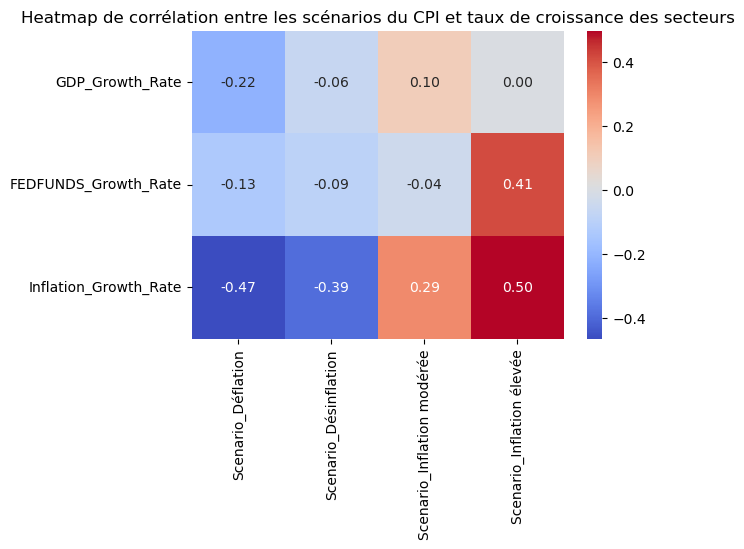

In [9]:
plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap de corrélation entre les scénarios du CPI et taux de croissance des secteurs')
plt.show()

### Partie 3: Analyse du comportement du CPI et du Taux d'intérét en fonction des scénarios de variabilité du GDP

**Scénarios traités pour GDP: Expansion économique, Récession économique, Ralentissement économique, Recouvrement économique**

In [10]:
def assign_scenario(row):
    GDP_Growth_Rate = row['GDP_Growth_Rate']
    Previous_GDP_Growth_Rate = row['Previous_GDP_Growth_Rate']

    if GDP_Growth_Rate > 0 and GDP_Growth_Rate > Previous_GDP_Growth_Rate:
        scenario = "Expansion économique"
    elif GDP_Growth_Rate < 0 and GDP_Growth_Rate < Previous_GDP_Growth_Rate:
        scenario = "Récession économique"
    elif GDP_Growth_Rate > 0 and GDP_Growth_Rate < Previous_GDP_Growth_Rate:
        scenario = "Ralentissement économique"
    elif GDP_Growth_Rate < 0 and GDP_Growth_Rate > Previous_GDP_Growth_Rate:
        scenario = "Recouvrement économique"
    else:
        scenario = None
    return scenario

merged_data['Scenario'] = merged_data.apply(assign_scenario, axis=1)

scenario_data = merged_data[['date', 'Scenario']].dropna()
scenario_data

,date,Scenario
2,2000-07-01,Ralentissement économique
3,2000-10-01,Expansion économique
4,2001-01-01,Récession économique
5,2001-04-01,Expansion économique
6,2001-07-01,Récession économique
...,...,...
97,2024-04-01,Expansion économique
98,2024-07-01,Ralentissement économique
99,2024-10-01,Ralentissement économique
100,2025-01-01,Récession économique


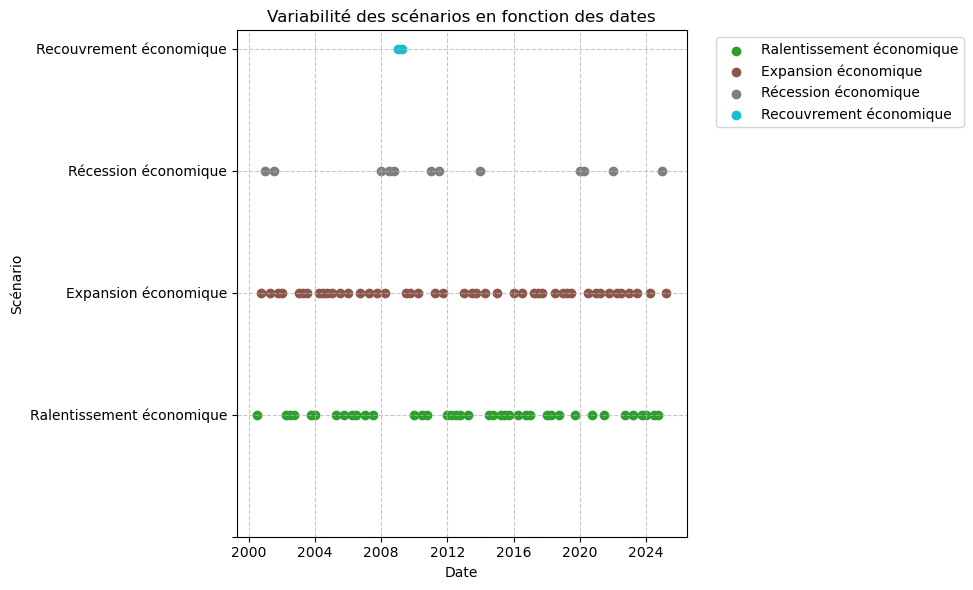

In [11]:
growth_rate = merged_data.drop(columns=['GDPC1', 'CPIAUCNS', 'FEDFUNDS', 'Previous_GDP_Growth_Rate', 'Previous_Inflation_Growth_Rate', 'Previous_FEDFUNDS_Growth_Rate'])

plt.figure(figsize=(10, 6))

unique_scenarios = growth_rate['Scenario'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_scenarios)))

for i, scenario in enumerate(unique_scenarios):
    scenario_data_subset = growth_rate[growth_rate['Scenario'] == scenario]
    plt.scatter(scenario_data_subset['date'], [i] * len(scenario_data_subset), color=colors[i], label=scenario)

plt.title('Variabilité des scénarios en fonction des dates')
plt.xlabel('Date')
plt.ylabel('Scénario')

plt.xticks(rotation=0, ha='center')

plt.yticks(np.arange(len(unique_scenarios)), unique_scenarios)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [12]:
start_date = '2000-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

filtered_data = merged_data[(merged_data['date'] >= start_date) & (merged_data['date'] <= end_date)]

scenario_counts = filtered_data['Scenario'].value_counts().reset_index()
scenario_counts.columns = ['Scenario', 'Count']

fig = px.pie(scenario_counts, values='Count', names='Scenario', title=f'Répartition des scénarios entre {start_date} et {end_date}')
fig.show()

In [13]:
merged_all_data_encoded = pd.get_dummies(scenario_data, columns=['Scenario'])

merged_all_data_encoded_no_date = merged_all_data_encoded.drop(columns='date')

growth_rate_reset = growth_rate.reset_index(drop=True)

final_data_for_corr = pd.concat(
    [merged_all_data_encoded_no_date,
     growth_rate_reset[['GDP_Growth_Rate', 'FEDFUNDS_Growth_Rate', 'Inflation_Growth_Rate']]],
    axis=1
)

correlation = final_data_for_corr.corr()

correlation = correlation.loc[
    ['GDP_Growth_Rate', 'FEDFUNDS_Growth_Rate', 'Inflation_Growth_Rate'],
    [col for col in correlation.columns if 'Scenario_' in col and 'Autres' not in col]
]

correlation

,Scenario_Expansion économique,Scenario_Ralentissement économique,Scenario_Recouvrement économique,Scenario_Récession économique
GDP_Growth_Rate,0.368032,-0.003353,-0.135046,-0.501220
FEDFUNDS_Growth_Rate,0.152451,-0.006230,-0.096017,-0.183058
Inflation_Growth_Rate,0.150165,-0.095407,-0.067212,-0.057521


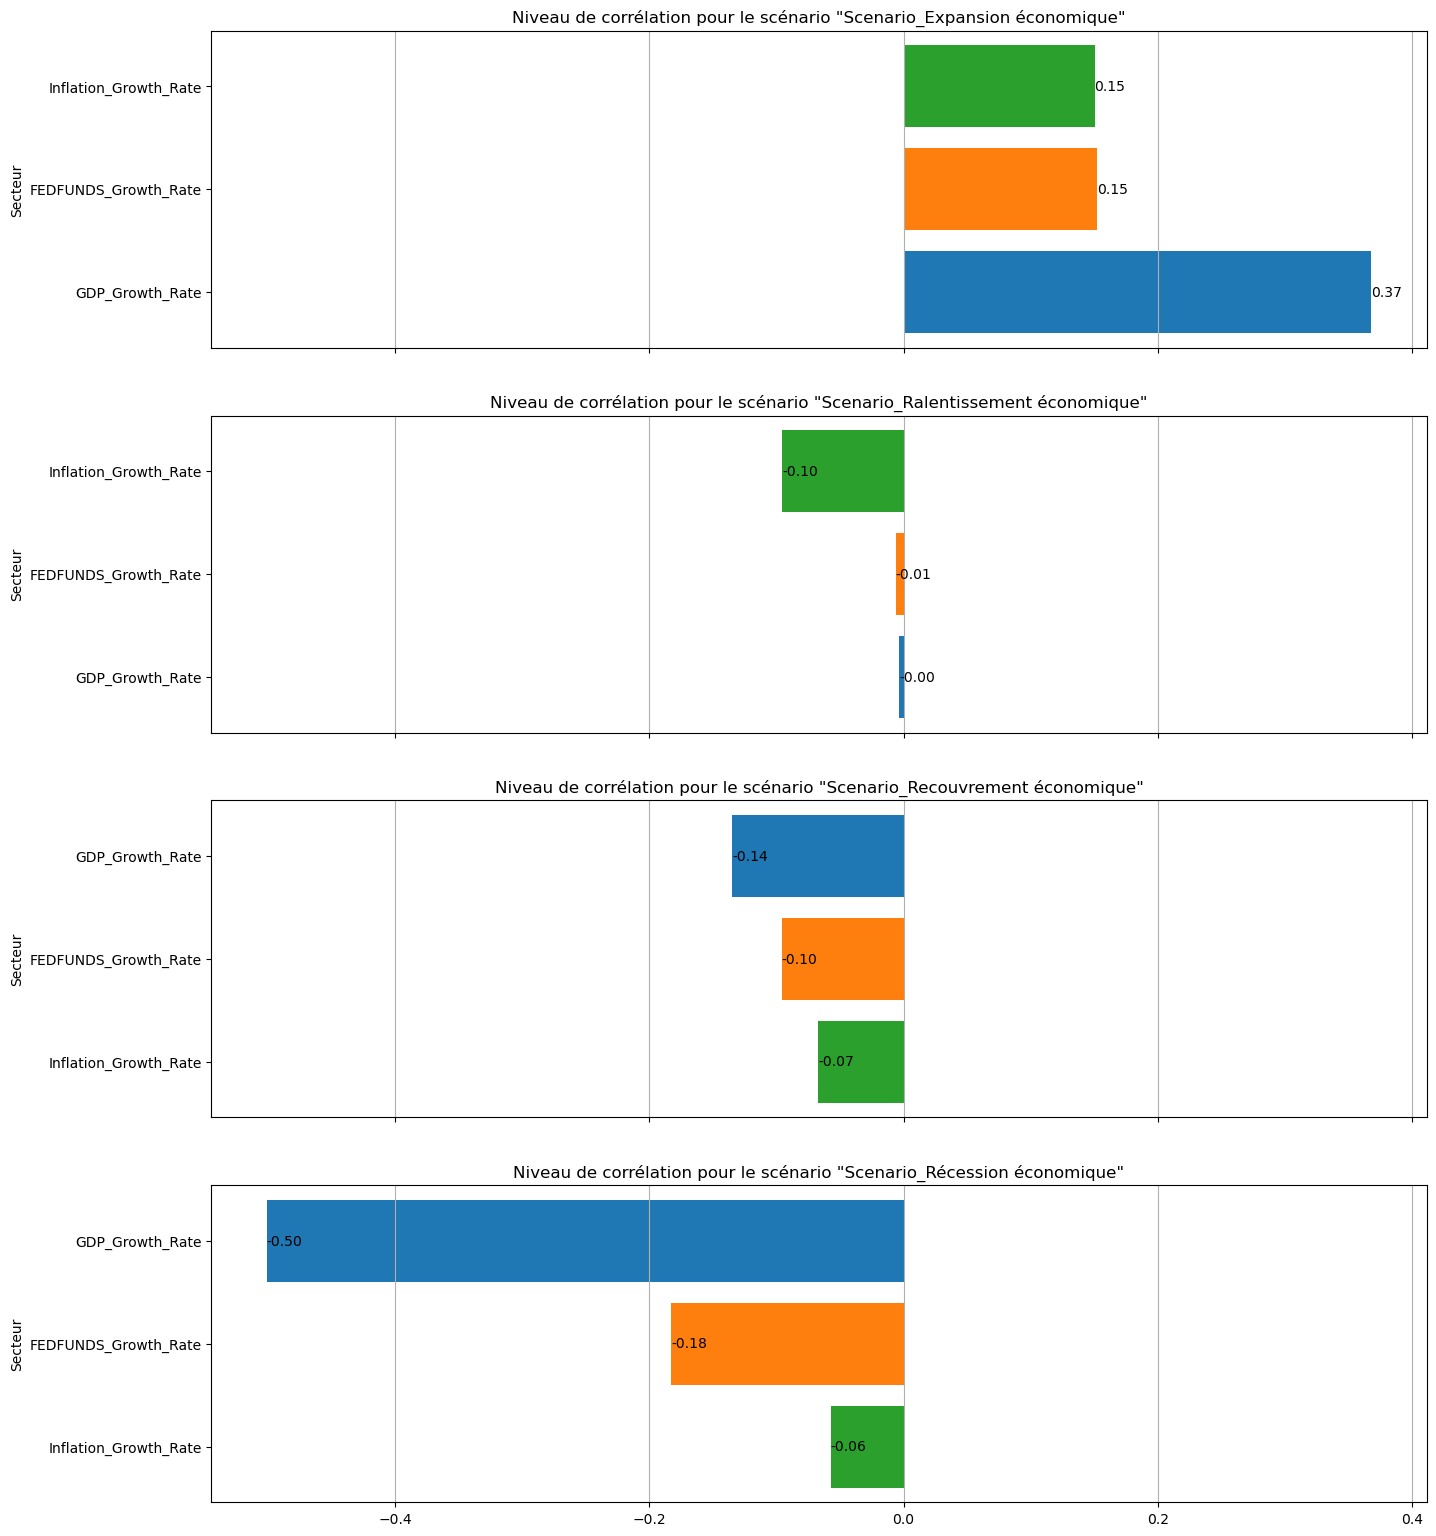

In [14]:
total_scenarios = len(correlation.columns)

sector_color_dict = {}
colors = plt.cm.tab10.colors[:len(correlation.index)]
for i, sector in enumerate(correlation.index):
    sector_color_dict[sector] = colors[i]

fig, axes = plt.subplots(total_scenarios, 1, figsize=(15, total_scenarios*4), sharex=True)

for i, scenario in enumerate(correlation.columns):
    sorted_sectors = correlation[scenario].sort_values(ascending=False)

    ax = axes[i]
    sectors = sorted_sectors.index
    scores = sorted_sectors.values

    colors = [sector_color_dict[sector] for sector in sectors]

    ax.barh(sectors, scores, color=colors)

    ax.set_ylabel('Secteur')
    ax.set_title(f'Niveau de corrélation pour le scénario "{scenario}"')
    ax.grid(axis='x')

    for j, score in enumerate(scores):
        ax.text(score, j, f'{score:.2f}', ha='left', va='center')

plt.tight_layout(pad=3.0)
plt.show()

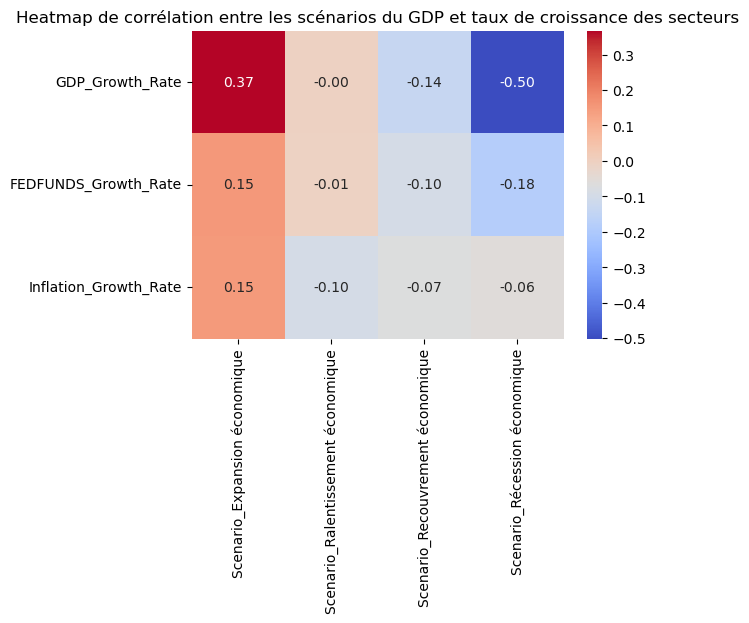

In [15]:
plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap de corrélation entre les scénarios du GDP et taux de croissance des secteurs')
plt.show()

### Partie 4: Analyse du comportement du CPI et du GDP en fonction des scénarios de variabilité du FEDFUNDS

**Scénarios traités pour FEDFUNDS: Baisse importante des taux d'intérêt, Baisse légère des taux d'intérêt, Baisse générale des taux d'intérêt, Hausse importante des taux d'intérêt, Hausse modérée des taux d'intérêt, Maintien des taux d'intérêt et Hausse générale des taux d'intérêt**

In [16]:
def assign_scenario(row):
    FEDFUNDS_Growth_Rate = row['FEDFUNDS_Growth_Rate']
    Previous_FEDFUNDS_Growth_Rate = row['Previous_FEDFUNDS_Growth_Rate']

    scenario = ""

    if FEDFUNDS_Growth_Rate < Previous_FEDFUNDS_Growth_Rate:
        if FEDFUNDS_Growth_Rate < -1:
            scenario = "Baisse importante des taux d'intérêt"
        elif -1 <= FEDFUNDS_Growth_Rate < 0:
            scenario = "Baisse légère des taux d'intérêt"
        else:
            scenario = "Baisse générale des taux d'intérêt"
    elif FEDFUNDS_Growth_Rate > Previous_FEDFUNDS_Growth_Rate:
        if FEDFUNDS_Growth_Rate >= 3:
            scenario = "Hausse importante des taux d'intérêt"
        elif 1 <= FEDFUNDS_Growth_Rate < 3:
            scenario = "Hausse modérée des taux d'intérêt"
        elif 0 <= FEDFUNDS_Growth_Rate < 1:
            scenario = "Maintien des taux d'intérêt"
        else:
            scenario = "Hausse générale des taux d'intérêt"
    else:
        scenario = None
    return scenario

merged_data['Scenario'] = merged_data.apply(assign_scenario, axis=1)

scenario_data = merged_data[['date', 'Scenario']].dropna()
scenario_data

,date,Scenario
2,2000-07-01,Baisse générale des taux d'intérêt
3,2000-10-01,Baisse légère des taux d'intérêt
4,2001-01-01,Baisse légère des taux d'intérêt
5,2001-04-01,Baisse légère des taux d'intérêt
6,2001-07-01,Hausse générale des taux d'intérêt
...,...,...
96,2024-01-01,Baisse générale des taux d'intérêt
98,2024-07-01,Baisse légère des taux d'intérêt
99,2024-10-01,Baisse légère des taux d'intérêt
100,2025-01-01,Hausse générale des taux d'intérêt


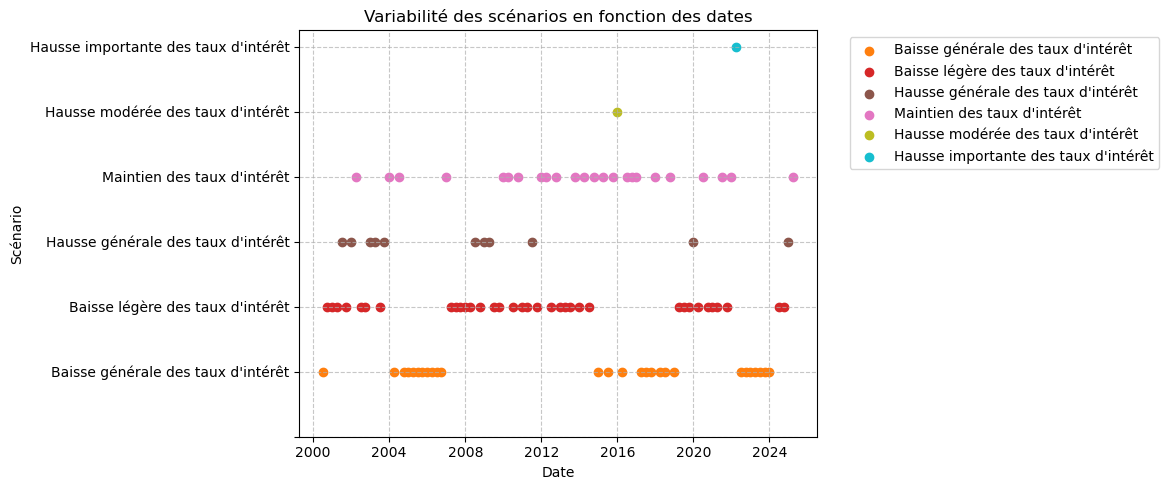

In [17]:
growth_rate = merged_data.drop(columns=['GDPC1', 'CPIAUCNS', 'FEDFUNDS', 'Previous_GDP_Growth_Rate', 'Previous_Inflation_Growth_Rate', 'Previous_FEDFUNDS_Growth_Rate'])

plt.figure(figsize=(12, 5))

unique_scenarios = growth_rate['Scenario'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_scenarios)))

for i, scenario in enumerate(unique_scenarios):
    scenario_data_subset = growth_rate[growth_rate['Scenario'] == scenario]
    plt.scatter(scenario_data_subset['date'], [i] * len(scenario_data_subset), color=colors[i], label=scenario)

plt.title('Variabilité des scénarios en fonction des dates')
plt.xlabel('Date')
plt.ylabel('Scénario')

plt.xticks(rotation=0, ha='center')

plt.yticks(np.arange(len(unique_scenarios)), unique_scenarios)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [18]:
start_date = '2000-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

filtered_data = merged_data[(merged_data['date'] >= start_date) & (merged_data['date'] <= end_date)]

scenario_counts = filtered_data['Scenario'].value_counts().reset_index()
scenario_counts.columns = ['Scenario', 'Count']

fig = px.pie(scenario_counts, values='Count', names='Scenario', title=f'Répartition des scénarios entre {start_date} et {end_date}')
fig.show()

In [19]:
merged_all_data_encoded = pd.get_dummies(scenario_data, columns=['Scenario'])

merged_all_data_encoded_no_date = merged_all_data_encoded.drop(columns='date')

growth_rate_reset = growth_rate.reset_index(drop=True)

final_data_for_corr = pd.concat(
    [merged_all_data_encoded_no_date,
     growth_rate_reset[['GDP_Growth_Rate', 'FEDFUNDS_Growth_Rate', 'Inflation_Growth_Rate']]],
    axis=1
)

correlation = final_data_for_corr.corr()

correlation = correlation.loc[
    ['GDP_Growth_Rate', 'FEDFUNDS_Growth_Rate', 'Inflation_Growth_Rate'],
    [col for col in correlation.columns if 'Scenario_' in col and 'Autres' not in col]
]

correlation

,Scenario_Baisse générale des taux d'intérêt,Scenario_Baisse légère des taux d'intérêt,Scenario_Hausse générale des taux d'intérêt,Scenario_Hausse importante des taux d'intérêt,Scenario_Hausse modérée des taux d'intérêt,Scenario_Maintien des taux d'intérêt
GDP_Growth_Rate,0.073825,-0.105894,-0.155915,-0.029589,0.004306,0.161645
FEDFUNDS_Growth_Rate,0.110219,-0.324414,-0.138436,0.850360,0.184491,0.107410
Inflation_Growth_Rate,0.041283,-0.050212,-0.061272,0.317151,-0.075979,0.001770


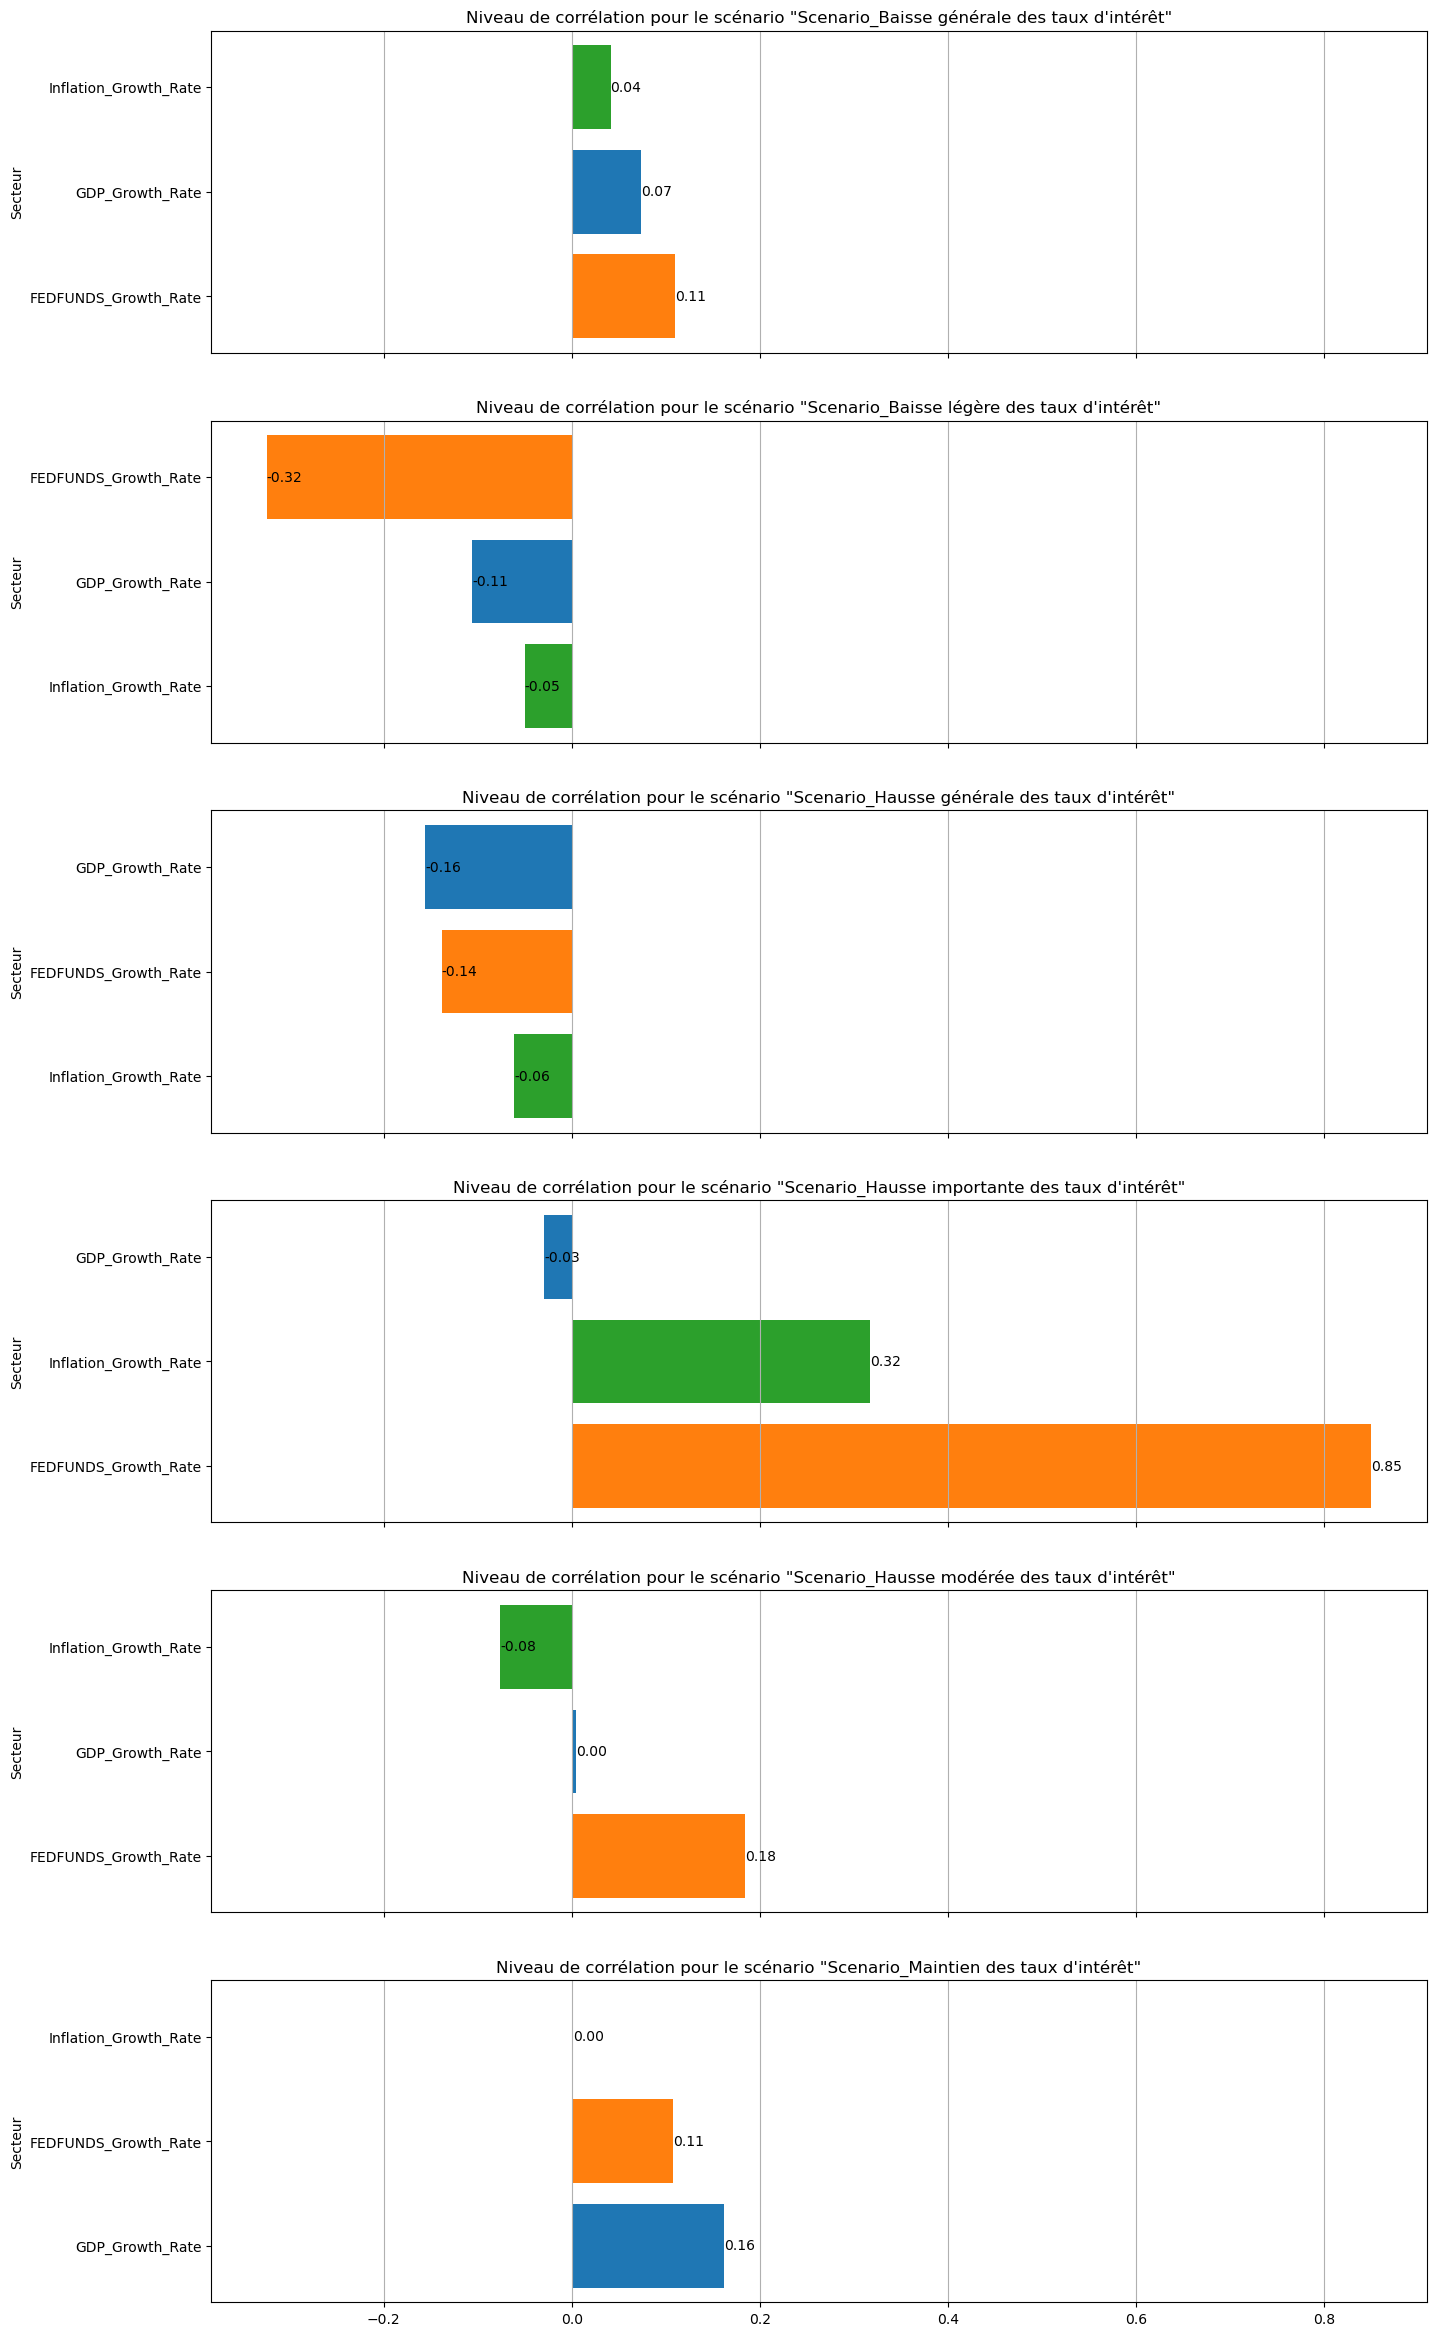

In [20]:
total_scenarios = len(correlation.columns)

sector_color_dict = {}
colors = plt.cm.tab10.colors[:len(correlation.index)]
for i, sector in enumerate(correlation.index):
    sector_color_dict[sector] = colors[i]

fig, axes = plt.subplots(total_scenarios, 1, figsize=(15, total_scenarios*4), sharex=True)

for i, scenario in enumerate(correlation.columns):
    sorted_sectors = correlation[scenario].sort_values(ascending=False)

    ax = axes[i]
    sectors = sorted_sectors.index
    scores = sorted_sectors.values

    colors = [sector_color_dict[sector] for sector in sectors]

    ax.barh(sectors, scores, color=colors)

    ax.set_ylabel('Secteur')
    ax.set_title(f'Niveau de corrélation pour le scénario "{scenario}"')
    ax.grid(axis='x')

    for j, score in enumerate(scores):
        ax.text(score, j, f'{score:.2f}', ha='left', va='center')

plt.tight_layout(pad=3.0)
plt.show()

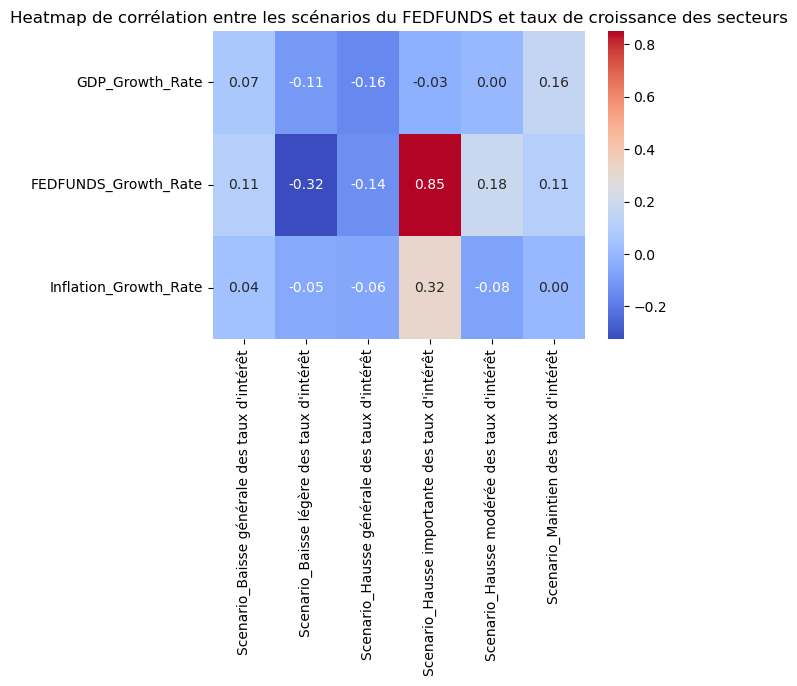

In [21]:
plt.figure(figsize=(6, 4))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap de corrélation entre les scénarios du FEDFUNDS et taux de croissance des secteurs')
plt.show()